### Import libraries

In [1]:
# Installation

# Import libs

import numpy as np
import pandas as pd
import sktime as sktime
import warnings

# Get functions from sktime

from sktime.datasets import load_airline
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    ReducedRegressionForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.utils.plotting import plot_series

# Models

from sklearn.neighbors import KNeighborsRegressor

# Filter warnings

warnings.filterwarnings("ignore")

# Ready to go

ModuleNotFoundError: No module named 'sktime'

### Get data

In [16]:
# Load example data

y = load_airline()

# Plot series

type(y)

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64


pandas.core.series.Series

In [10]:
y.index

PeriodIndex(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
             '1949-07', '1949-08', '1949-09', '1949-10',
             ...
             '1960-03', '1960-04', '1960-05', '1960-06', '1960-07', '1960-08',
             '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', name='Period', length=144, freq='M')

### Train test strategy

108 36


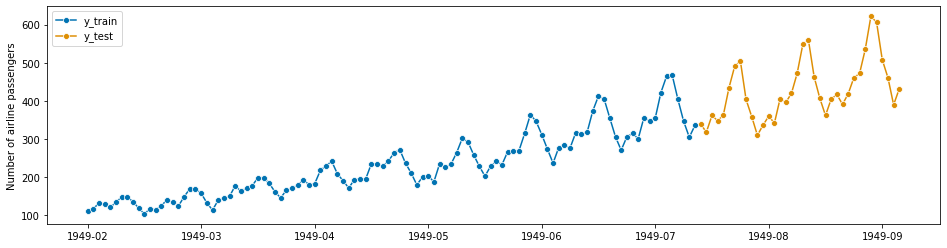

In [11]:
# Y train and Y test

y_train, y_test = temporal_train_test_split(y, test_size=36)

# Plot 

plot_series(y_train, y_test, labels=["y_train", "y_test"])

print(y_train.shape[0], y_test.shape[0])

### Horizon

In [17]:
fh = np.arange(len(y_test)) + 1
fh
y_train

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1957-08    467.0
1957-09    404.0
1957-10    347.0
1957-11    305.0
1957-12    336.0
Freq: M, Name: Number of airline passengers, Length: 108, dtype: float64

### Forecast

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


0.23195770387951434

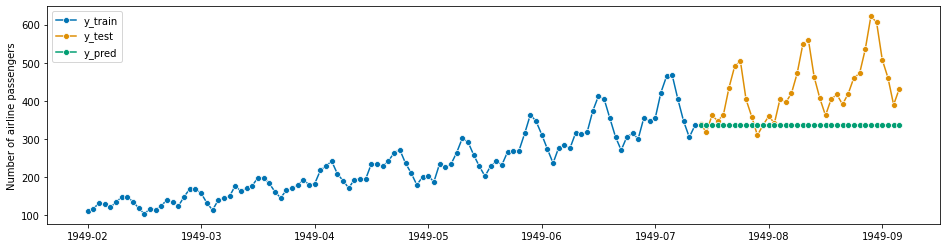

In [15]:
# Naive

forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

0.145427686270316

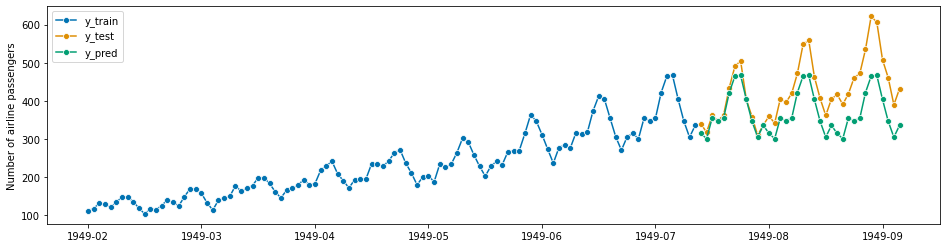

In [17]:
# Seasonal Naive

forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

0.05144371423878427

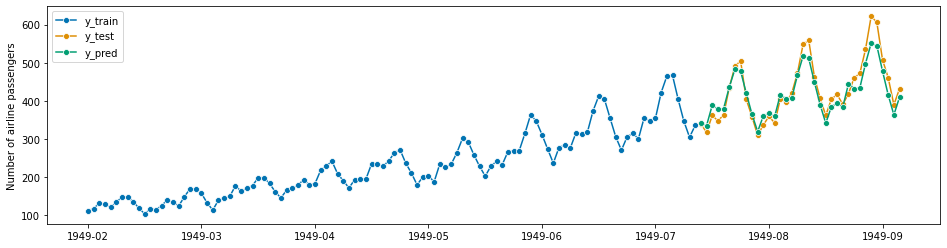

In [18]:
# Exp smoothing

forecaster = ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

0.0631622209514497

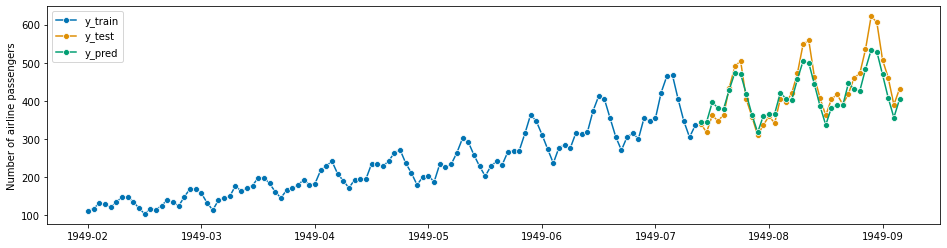

In [20]:
# ETS

from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

0.04117062370076287

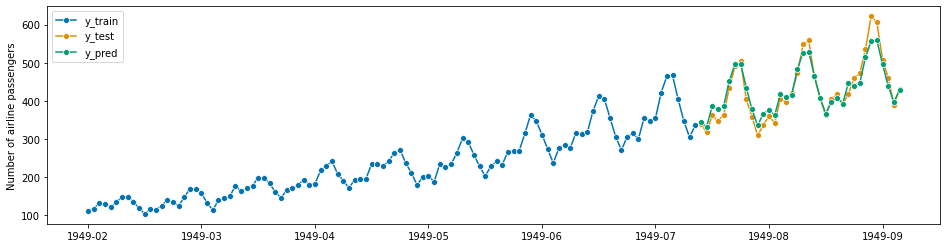

In [21]:
# Auto Arima

forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

0.07924714053033904

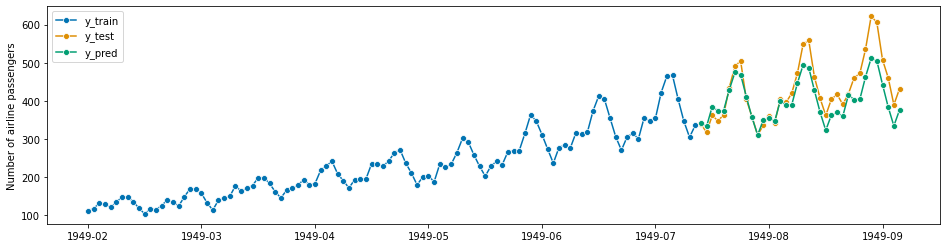

In [22]:
# Ensemble

forecaster = EnsembleForecaster(
    [
        ("ses", ExponentialSmoothing(seasonal="multiplicative", sp=12)),
        (
            "holt",
            ExponentialSmoothing(
                trend="add", damped=False, seasonal="multiplicative", sp=12
            ),
        ),
        (
            "damped",
            ExponentialSmoothing(
                trend="add", damped=True, seasonal="multiplicative", sp=12
            ),
        ),
    ]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

{'window_length': 15}

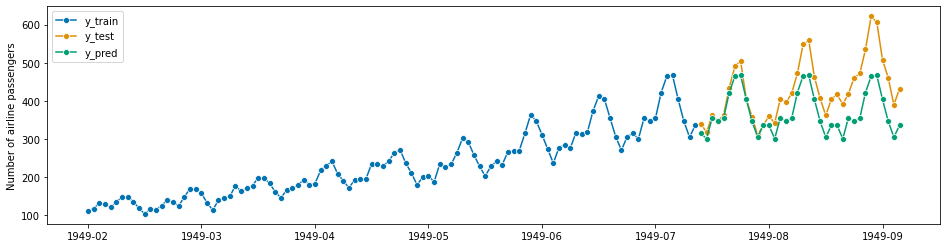

In [25]:
# Reduced regression

regressor = KNeighborsRegressor(n_neighbors=1)

forecaster = ReducedRegressionForecaster(
    regressor = regressor, window_length=15, strategy="recursive"
)
param_grid = {"window_length": [5, 10, 15]}

# we fit the forecaster on the initial window and then use temporal cross-validation to find the optimal parameter

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)
gscv.fit(y_train)
y_pred = gscv.predict(fh)

# Plot

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

# Best window

gscv.best_params_


0.08661468194921726

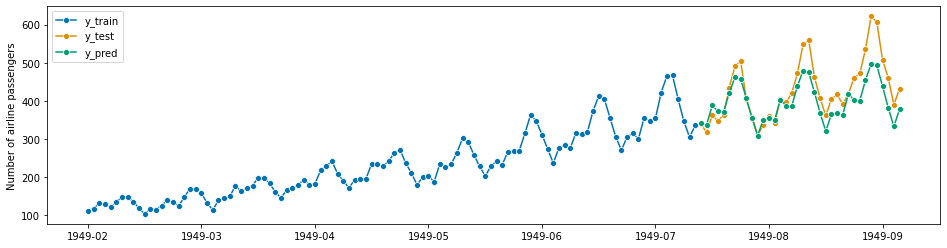

In [27]:
# Theta

forecaster = ThetaForecaster(sp=12)
forecaster.fit(y_train)
alpha = 0.05  # 95% prediction intervals
y_pred, pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)